In [7]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32
import nbimporter
import Toollib 
import pandas as pd
import hashlib

In [1]:
import os, re
imagelist = os.listdir('image')
imagelist = [re.sub(r'.tiff', '', i) for i in imagelist]

In [2]:
imagelist

['Baboon', 'house', 'Jet', 'Lena', 'Peppers', 'Sailboat', 'Splash', 'Tiffany']

In [3]:
import hashlib

def generate_authentication_code(gvi, rmi, bmi, i, j):
    input_string = str(gvi) + str(rmi) + str(bmi) + str(i) + str(j)
    hash_object = hashlib.md5(input_string.encode())
    hash_code = hash_object.digest()
    # 將二進位制的哈希值轉換為十進位數字
    hash_int = int.from_bytes(hash_code, byteorder='big')
    return hash_int

In [4]:
def AVGI(Graph,lr=4,lb=4):
    path = 'image/'+Graph+'.tiff'
    I=io.imread(path)
    Stego = I.copy()

    p = 0
    MSE = 0
    F = 0
    N = 0
    X = 0
    delta_RB_List = []

    for i in range(Stego.shape[0]):
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            zero_lr =np.zeros(lr)
            zero_lb =np.zeros(lb)
            Stego[i,j,0] = bitsetting.lsbset(Stego[i,j,0],zero_lr)
            Stego[i,j,2] = bitsetting.lsbset(Stego[i,j,2],zero_lb)
            
            ac = generate_authentication_code(G_round, Stego[i,j,0], Stego[i,j,1], i, j)    
            ac = Toollib.fold(ac,lr+lb)
            
            bin = B2D.Dec2Bin(ac,lr+lb)
            upper = bin[0:lr]
            lower = bin[lr:]
            
            k=[]
            Stego[i,j,0] = bitsetting.lsbset(Stego[i,j,0],upper)
            k.append(Stego[i,j,0])
            Stego[i,j,2] = bitsetting.lsbset(Stego[i,j,2],lower)  
            k.append(Stego[i,j,2])
            g_bar = int((Gray - 0.299*k[0] - 0.114*k[1])/0.587)
            
            if(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) < round(Gray)):
                g_bar += 1
            elif(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) > round(Gray)):
                g_bar -= 1

            if(g_bar > 255 or g_bar < 0):
                p += 1
                ac_fold = Toollib.fold(ac,2)
                Stego[i,j] = Toollib.remedy(Stego[i,j,0],Stego[i,j,1],Stego[i,j,2],ac_fold)
            else:
                Stego[i,j,1] = g_bar

            # print(f"I:{I[i,j]}, S:{Stego[i,j]}, g_bar:{(Gray - 0.299*k[0] - 0.114*k[1])/0.587}, k:{k}")

            X = 0
            delta_B = int(Stego[i,j,2]) - int(I[i,j,2])
            MSE += delta_B ** 2
            delta_G = int(Stego[i,j,1]) - int(I[i,j,1])
            MSE += delta_G ** 2 
            delta_R = int(Stego[i,j,0]) - int(I[i,j,0])
            MSE += delta_R ** 2    

            delta_RB_List.append((delta_R, delta_B))            

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p} , X:{N}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)
    return delta_RB_List

In [5]:
def RB_histogram_Variation_Frequency(delta_RB,image):
    delta_RB_ravel = delta_RB.ravel()
    delta_RB_ravel = np.abs(delta_RB_ravel)
    bins = range(0, 16)
    counts, edges = np.histogram(delta_RB_ravel, bins=bins)
    print(counts)

    # 繪製長條圖
    plt.bar(edges[:-1], counts, width=1, edgecolor="black", align="edge")

    # 設置橫軸範圍和標籤
    # plt.xticks(range(0, 16))
    # plt.xlabel("Variation")
    # plt.ylabel("Frequency")
    # plt.title("Hong's method (2020)")
    
    plt.savefig(f"Variation-Frequency/{image}_APPM.png")
    # 顯示圖表
    plt.show()
    

PSNR:36.126214772074505 , F:12 , N:9448


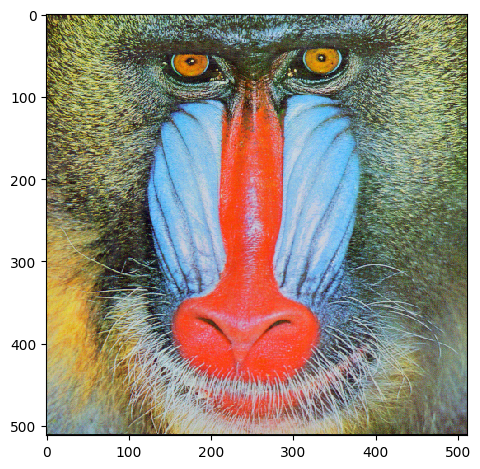

[34930 71735 71763 71754 67502 61195 56245 48099 31617  9367    56    15
     5     4     1]


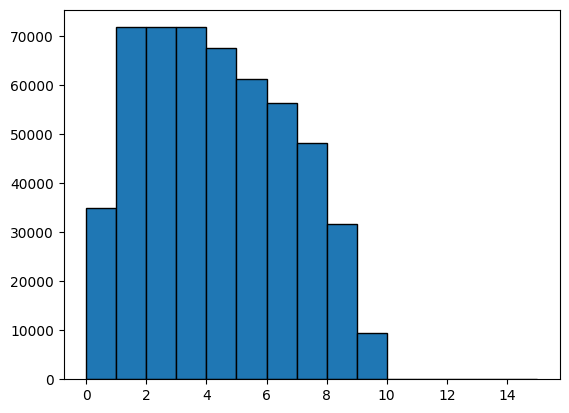

PSNR:36.145914092786946 , F:561 , N:8922


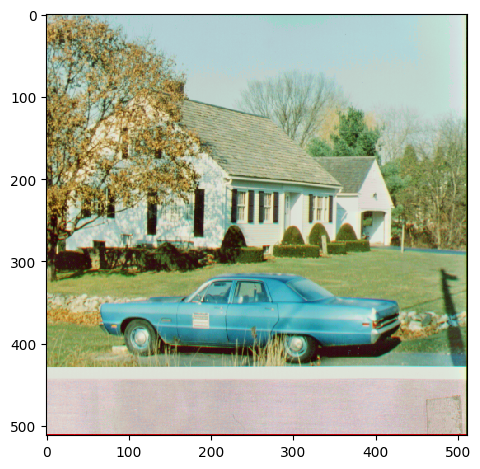

[35566 70175 70914 72236 68122 60930 56321 49121 31949  8848    25    17
    34     4    26]


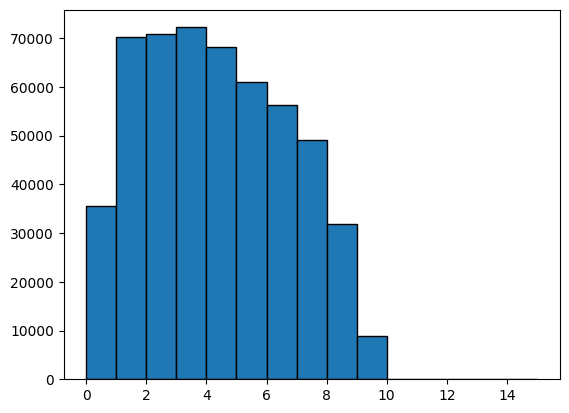

PSNR:36.0657576372427 , F:257 , N:6474


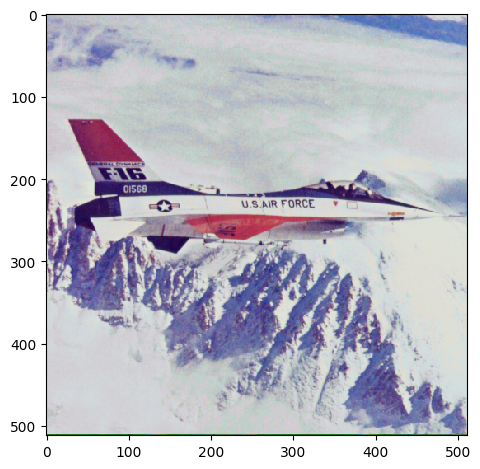

[29355 61656 63869 71011 74604 79157 64432 46236 27494  6474     0     0
     0     0     0]


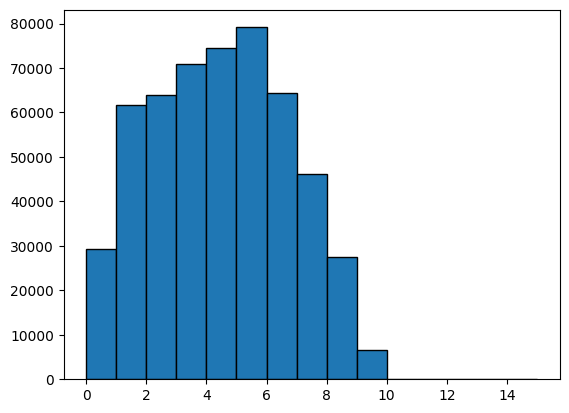

PSNR:36.07771390786017 , F:1 , N:10328


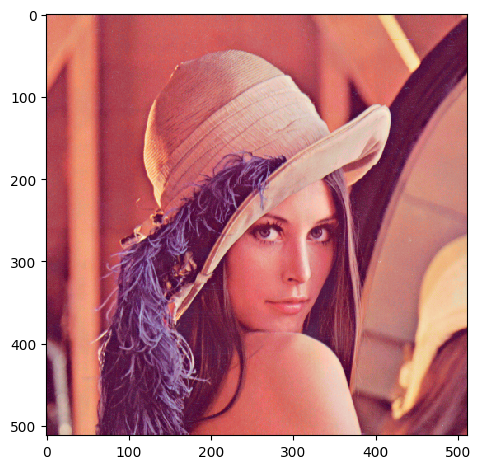

[34399 70236 70086 71838 68738 61692 57066 48046 31825  9816   223   181
    78    53    11]


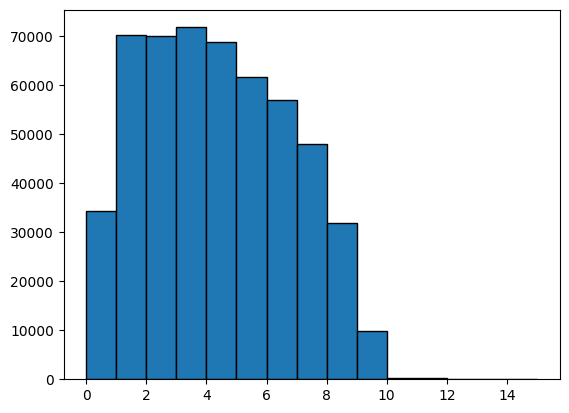

PSNR:35.95051887298045 , F:8621 , N:15334


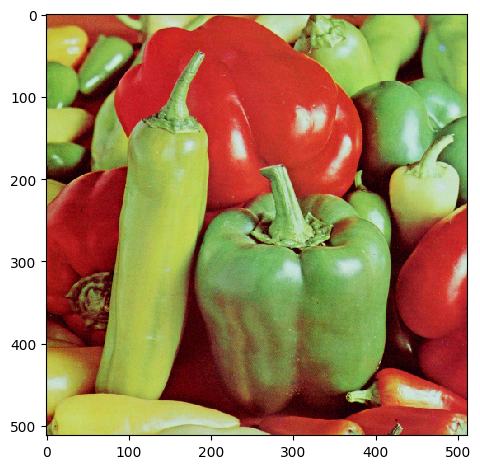

[35621 71028 71030 70759 66433 59329 55268 47278 32147 11185  2053  1802
   228    70    57]


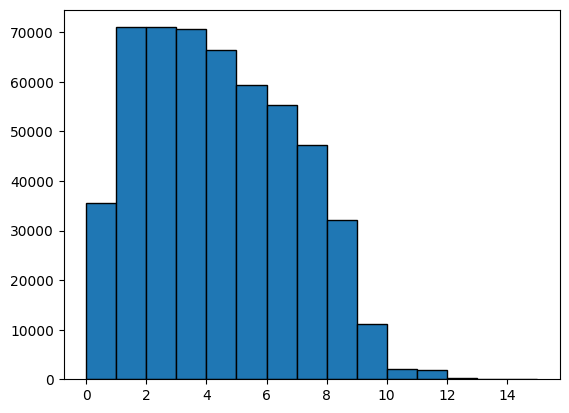

PSNR:36.18668319588694 , F:797 , N:8667


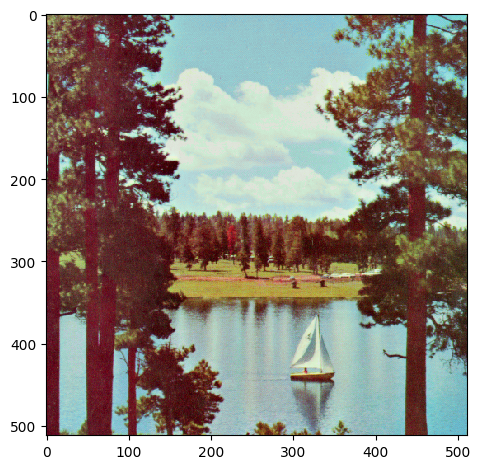

[34403 72166 72099 72695 69199 61823 56043 46497 30687  8426   105    78
    51    10     6]


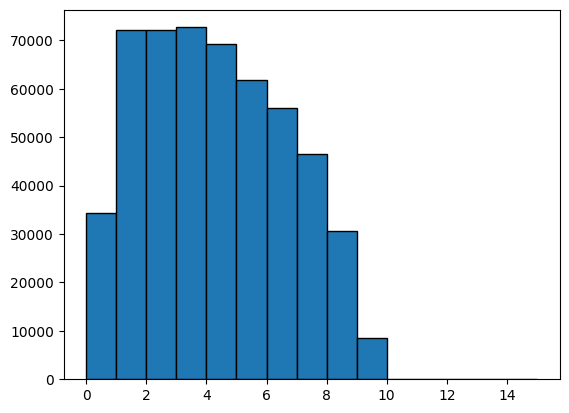

PSNR:36.12429907963111 , F:7570 , N:9381


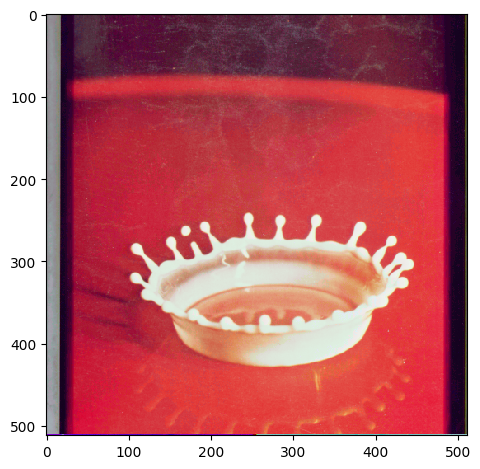

[34150 70516 71386 72823 68814 61691 56516 47664 31347  9380     0     1
     0     0     0]


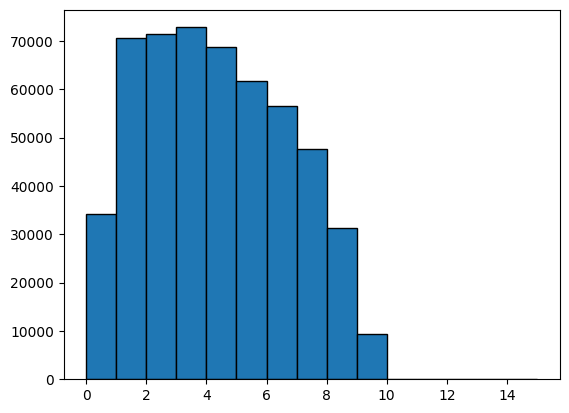

PSNR:33.168796187678126 , F:20310 , N:97648


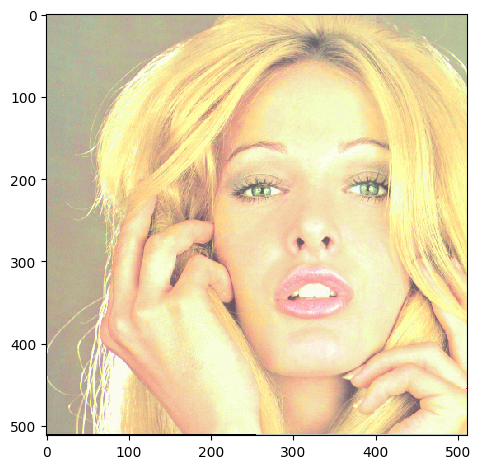

[26468 50428 71215 53532 49234 43855 40757 55716 25398 15515  9791 69213
  2542  2288  7227]


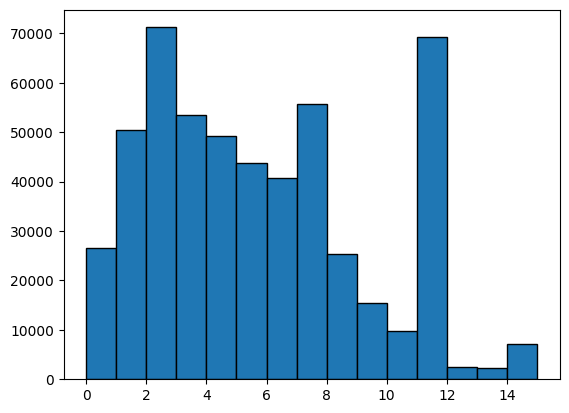

In [8]:
for image in imagelist:
    delta_RB = Toollib.AVGI(image)
    delta_RB = np.array(delta_RB)
    RB_histogram_Variation_Frequency(delta_RB,image)